In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
import plotly.express as px
from tqdm import tqdm

In [2]:
base_dir=os.path.join("/content","drive","MyDrive","archive","people_segmentation")

In [3]:
def load_corrosponding_mask(img_name,base_dir):
  return plt.imread(os.path.join(base_dir,'masks',img_name.split('.')[0]+".png"))

In [4]:
def show_demo_pics(n_samples=3):
  img=os.listdir(os.path.join(base_dir,'train','images'))
  img_sampled=random.sample(img,n_samples)
  img_sampled_masks=list(map(load_corrosponding_mask,img_sampled,[os.path.join(base_dir,'train')]*n_samples))
  plt.figure(figsize=(10,10))
  for i in range(n_samples):
    plt.subplot(n_samples,2,2*i+1)
    plt.imshow(plt.imread(os.path.join(base_dir,'train','images',img_sampled[i])))

    plt.subplot(n_samples,2,2*i+2)
    plt.imshow(img_sampled_masks[i])

    plt.axis('off')

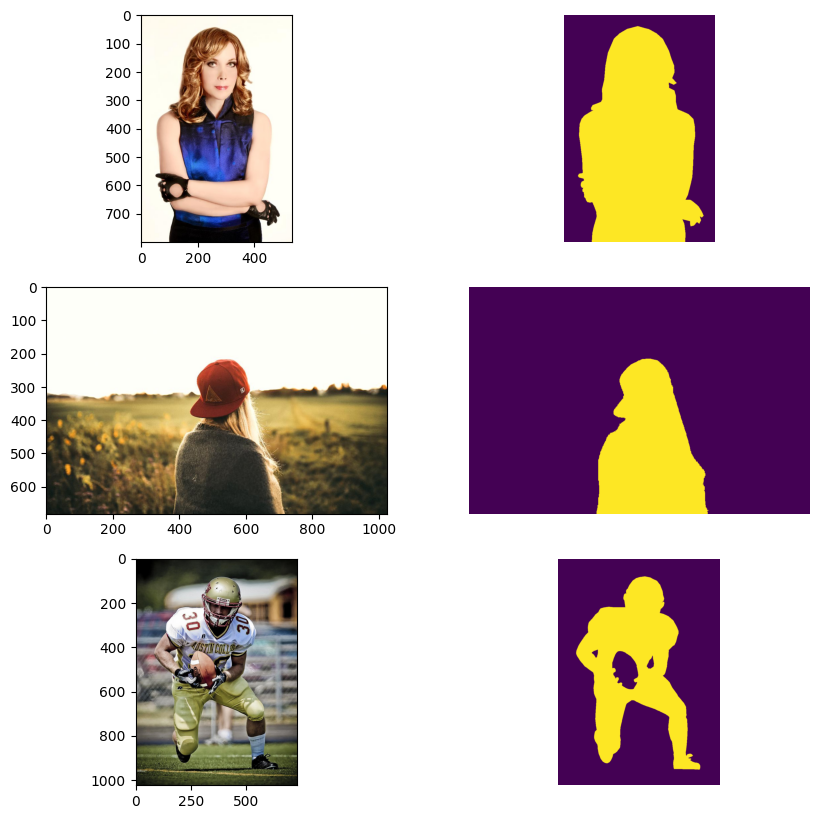

In [5]:
show_demo_pics()

In [6]:
def get_img_shape(img_path):
  img=cv2.imread(img_path)
  return img.shape

In [7]:
import hashlib
def create_hash(img_id,base_dir):
    with open(os.path.join(base_dir,'images',img_id),'rb') as f:
        file_hash=hashlib.md5(f.read()).hexdigest()
    return file_hash

In [15]:
cnt=0
total_no_of_images=len(os.listdir(os.path.join(base_dir,'train','images')))*2
def util(img,base_dir):
    global img_name, img_shape, mask_shape, cnt,img_hash

    try:
        img_path = os.path.join(base_dir, 'images', img)
        mask_path = os.path.join(base_dir, 'masks', img.split('.')[0] + ".png")

        # Open both first to ensure success
        with Image.open(img_path) as im, Image.open(mask_path) as mask:
            with lock:
                img_name.append(img)
                img_shape.append(im.size)
                mask_shape.append(mask.size)
                img_hash.append(create_hash(img,base_dir))
                cnt += 2
                if cnt % 100 == 0:
                  print(f"{cnt * 100 / total_no_of_images:.2f}% done")
                  print(len(img_name), len(img_shape), len(mask_shape))

    except Exception as e:
        print(f"⚠️ Error with {img}: {e}")


In [16]:
os.path.join(base_dir,'train','images')

'/content/drive/MyDrive/archive/people_segmentation/train/images'

In [17]:
%%time
img_name=[]
img_shape=[]
mask_shape=[]
img_hash=[]
cnt=0
lock=None
def fn(subset):
  global img_name, img_shape, mask_shape, cnt,img_hash,lock
  cnt=0
  img_name=[]
  img_shape=[]
  mask_shape=[]
  img_hash=[]
  from concurrent.futures import ThreadPoolExecutor
  import threading

  dir_path = os.path.join(base_dir, subset)
  img_list = os.listdir(os.path.join(dir_path, 'images'))

  lock=threading.Lock()
  with ThreadPoolExecutor(max_workers=10) as pool:
    pool.map(lambda x:util(x,dir_path),img_list)

  return pd.DataFrame({'img_name':img_name,'img_shape':img_shape,'mask_shape':mask_shape,'img_hash':img_hash})

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 15.7 µs


In [18]:
train_df=fn('train')
val_df=fn('val')
test_df=fn('test')

1.39% done
50 50 50
2.79% done
100 100 100
4.18% done
150 150 150
5.57% done
200 200 200
6.96% done
250 250 250
8.36% done
300 300 300
9.75% done
350 350 350
11.14% done
400 400 400
12.53% done
450 450 450
13.93% done
500 500 500
15.32% done
550 550 550
16.71% done
600 600 600
18.11% done
650 650 650
19.50% done
700 700 700
20.89% done
750 750 750
22.28% done
800 800 800
23.68% done
850 850 850
25.07% done
900 900 900
26.46% done
950 950 950
27.86% done
1000 1000 1000
29.25% done
1050 1050 1050
30.64% done
1100 1100 1100
32.03% done
1150 1150 1150
33.43% done
1200 1200 1200
34.82% done
1250 1250 1250
36.21% done
1300 1300 1300
37.60% done
1350 1350 1350
39.00% done
1400 1400 1400
40.39% done
1450 1450 1450
41.78% done
1500 1500 1500
43.18% done
1550 1550 1550
44.57% done
1600 1600 1600
45.96% done
1650 1650 1650
47.35% done
1700 1700 1700
48.75% done
1750 1750 1750
50.14% done
1800 1800 1800
51.53% done
1850 1850 1850
52.92% done
1900 1900 1900
54.32% done
1950 1950 1950
55.71% done
20

In [19]:
train_df.head()

,img_name,img_shape,mask_shape,img_hash
0,pexels-photo-722752.jpg,"(768, 1024)","(768, 1024)",63d5721f93389113825f9b78b9a177c1
1,pexels-photo-745128.jpg,"(1024, 682)","(1024, 682)",53c7b64b38f3f51c063dc8a8775faef3
2,pexels-photo-746891.jpg,"(1024, 682)","(1024, 682)",a4744dc0bbecd639b0f25253ded2403d
3,pexels-photo-736508.jpg,"(1024, 682)","(1024, 682)",69e1cd56e7d464ddaf892523d6a1d7de
4,pexels-photo-733496.jpg,"(533, 800)","(533, 800)",8aebe7583e5090a37f5bc7ef8e7cc891


In [20]:
train_df['img_shape']=train_df['img_shape'].apply(lambda x:str(x))
train_df['mask_shape']=train_df['mask_shape'].apply(lambda x:str(x))

In [21]:
px.histogram(train_df,x='img_shape').show()
px.histogram(train_df,x='mask_shape').show()

In [22]:
# ensuring if images are in same order in directory to use image data generator
def random_select_img_and_mask(n_samples=3):
  img=os.listdir(os.path.join(base_dir,'train','images'))
  masks=os.listdir(os.path.join(base_dir,'train','masks'))
  # random points
  rand_index=random.sample(range(len(img)),n_samples)
  plt.figure(figsize=(15,10))
  for i in range(len(rand_index)):
    plt.subplot(2,n_samples,i+1)
    plt.imshow(plt.imread(os.path.join(base_dir,'train','images',img[rand_index[i]])))
    plt.title(img[rand_index[i]])

    plt.subplot(2,n_samples,i+1+n_samples)
    plt.imshow(plt.imread(os.path.join(base_dir,'train','masks',masks[rand_index[i]])),cmap='gray')
    plt.title(masks[rand_index[i]])

    plt.axis('off')

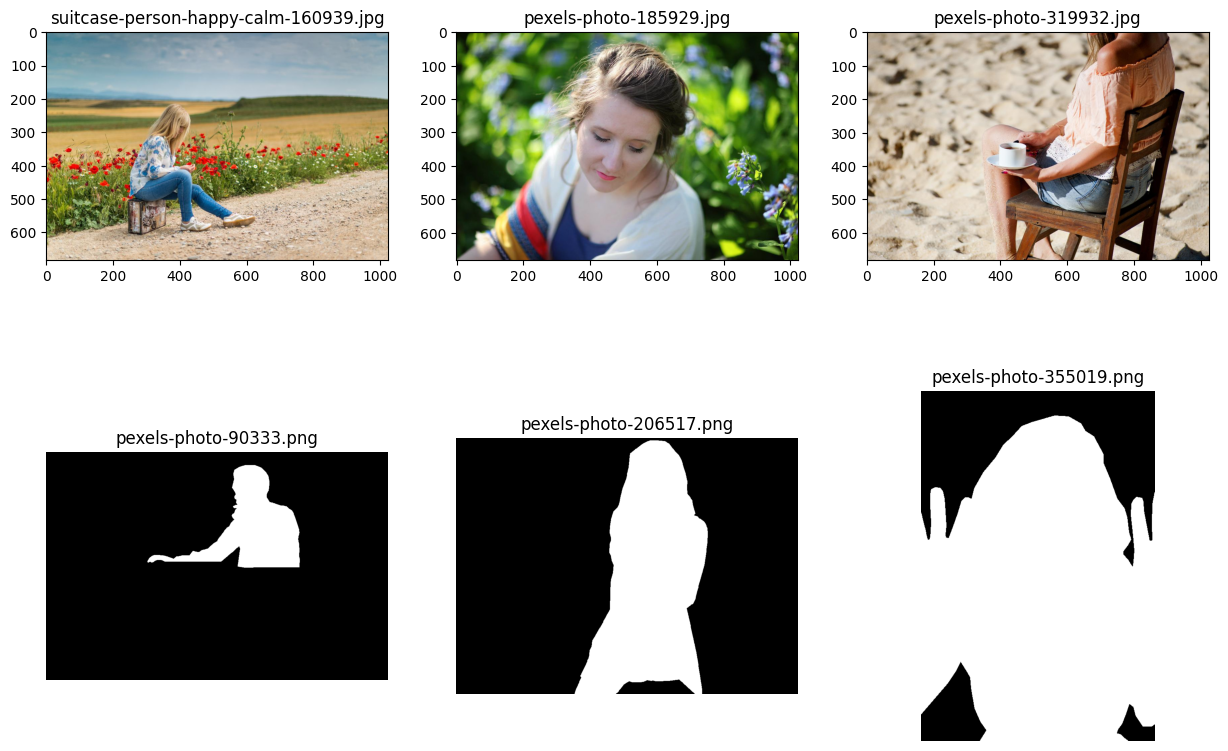

In [23]:
random_select_img_and_mask()

In [24]:
# if we will use data generator then it can cause error because images and masks are not in order
# so i will create df for corresponding images and masks

In [25]:
train_df['mask_name']=train_df['img_name'].apply(lambda x:x.split('.')[0]+".png")
val_df['mask_name']=val_df['img_name'].apply(lambda x:x.split('.')[0]+".png")
test_df['mask_name']=test_df['img_name'].apply(lambda x:x.split('.')[0]+".png")

In [26]:
# looking for duplicates using hashing
train_df['img_hash'].duplicated().sum(),
val_df['img_hash'].duplicated().sum(),
test_df['img_hash'].duplicated().sum()

np.int64(0)

In [27]:
train_df.drop_duplicates(subset=['img_hash'],inplace=True)
val_df.drop_duplicates(subset=['img_hash'],inplace=True)
test_df.drop_duplicates(subset=['img_hash'],inplace=True)

In [28]:
train_df.drop(columns=['img_hash','img_shape','mask_shape'],inplace=True)
test_df.drop(columns=['img_hash','img_shape','mask_shape'],inplace=True)
val_df.drop(columns=['img_hash','img_shape','mask_shape'],inplace=True)

# creating model

In [29]:
input_shape=(512,512,3)
mask_shape=(512,512,1)
BATCH_SIZE=32

In [30]:
# we will set input target_size=512*512
def create_conv_block(n1,n2,k1,k2,l):
  l=layers.Conv2D(n1,k1,activation='relu',padding='same')(l)
  l=layers.Conv2D(n2,k2,activation='relu',padding='same')(l)
  return l

In [31]:
input=layers.Input(shape=input_shape)

c1=create_conv_block(16,16,3,3,input)

c2=layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(c1)
c2=create_conv_block(32,32,3,3,c2)

c3=layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(c2)
c3=create_conv_block(64,64,3,3,c3)

c4=layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(c3)
c4=create_conv_block(128,128,3,3,c4)


bottom=layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(c4)
conv_1x1=layers.Conv2D(256,1,activation='relu',padding='same')(bottom)
conv_1x1_2=layers.Conv2D(256,1,activation='relu',padding='same')(conv_1x1)

c4_up=layers.Conv2DTranspose(128,2,strides=(2,2),padding='same')(conv_1x1_2)
c4_up=layers.concatenate([c4,c4_up])
c4_up=create_conv_block(128,128,3,3,c4_up)

c3_up=layers.Conv2DTranspose(64,2,strides=(2,2),padding='same')(c4_up)
c3_up=layers.concatenate([c3,c3_up])
c3_up=create_conv_block(64,64,3,3,c3_up)

c2_up=layers.Conv2DTranspose(32,2,strides=(2,2),padding='same')(c3_up)
c2_up=layers.concatenate([c2,c2_up])
c2_up=create_conv_block(32,32,3,3,c2_up)

c1_up=layers.Conv2DTranspose(16,2,strides=(2,2),padding='same')(c2_up)
c1_up=layers.concatenate([c1,c1_up])
c1_up=create_conv_block(16,16,3,3,c1_up)

output=layers.Conv2D(1,1,activation='sigmoid')(c1_up)


model=keras.Model(inputs=input,outputs=output)

In [32]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     33,024 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     65,792 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    131,200 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_7[0][0], 

 Total params: 1,154,673 (4.40 MB)

 Trainable params: 1,154,673 (4.40 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
import tensorflow.keras.backend as K
def mean_iou(y_true, y_pred,smooth=1):
    # plt.imshow(y_pred)
    # plt.show()
    # plt.imshow(y_true)
    # plt.show()
    y_true=K.flatten(y_true)
    y_pred=K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

In [44]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy',mean_iou])

In [45]:
train_data_X=keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)
val_data_X=keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)
test_data_X=keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)
train_data_y=keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)
val_data_y=keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)
test_data_y=keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

train_data_X=train_data_X.flow_from_dataframe(train_df,x_col='img_name',class_mode=None,directory=os.path.join(base_dir,'train','images'),target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE)
val_data_X=val_data_X.flow_from_dataframe(val_df,x_col='img_name',class_mode=None,directory=os.path.join(base_dir,'val','images'),target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE)
test_data_X=test_data_X.flow_from_dataframe(test_df,x_col='img_name',class_mode=None,directory=os.path.join(base_dir,'test','images'),target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE)

train_data_y=train_data_y.flow_from_dataframe(train_df,x_col='mask_name',class_mode=None,directory=os.path.join(base_dir,'train','masks'),target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE,color_mode='grayscale')
val_data_y=val_data_y.flow_from_dataframe(val_df,x_col='mask_name',class_mode=None,directory=os.path.join(base_dir,'val','masks'),target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE,color_mode='grayscale')
test_data_y=test_data_y.flow_from_dataframe(test_df,x_col='mask_name',class_mode=None,directory=os.path.join(base_dir,'test','masks'),target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE,color_mode='grayscale')


Found 3590 validated image filenames.
Found 898 validated image filenames.
Found 1123 validated image filenames.
Found 3590 validated image filenames.
Found 898 validated image filenames.
Found 1123 validated image filenames.


In [46]:
# !cp -r /content/drive/MyDrive/archive/people_segmentation /content/drive/MyDrive/archive/people_segmentation_backup

In [47]:
# # one time thing on dataset
# # dividing original folder into two 3 subfloder train,val,test
# from sklearn.model_selection import train_test_split

# train_df,test_df=train_test_split(df,test_size=0.2,random_state=42)
# train_df,val_df=train_test_split(train_df,test_size=0.2,random_state=42)

# os.mkdir(os.path.join(base_dir,'train'))
# os.mkdir(os.path.join(base_dir,'val'))
# os.mkdir(os.path.join(base_dir,'test'))

# os.mkdir(os.path.join(base_dir,'train','images'))
# os.mkdir(os.path.join(base_dir,'train','masks'))
# os.mkdir(os.path.join(base_dir,'val','images'))
# os.mkdir(os.path.join(base_dir,'val','masks'))
# os.mkdir(os.path.join(base_dir,'test','images'))
# os.mkdir(os.path.join(base_dir,'test','masks'))

# for img_name,mask_name in zip(train_df['img_name'].values,train_df['mask_name'].values):
#   os.rename(os.path.join(base_dir,'images',img_name),os.path.join(base_dir,'train','images',img_name))
#   os.rename(os.path.join(base_dir,'masks',mask_name),os.path.join(base_dir,'train','masks',mask_name))

# for img_name,mask_name in zip(val_df['img_name'].values,val_df['mask_name'].values):
#   os.rename(os.path.join(base_dir,'images',img_name),os.path.join(base_dir,'val','images',img_name))
#   os.rename(os.path.join(base_dir,'masks',mask_name),os.path.join(base_dir,'val','masks',mask_name))

# for img_name,mask_name in zip(test_df['img_name'].values,test_df['mask_name'].values):
#   os.rename(os.path.join(base_dir,'images',img_name),os.path.join(base_dir,'test','images',img_name))
#   os.rename(os.path.join(base_dir,'masks',mask_name),os.path.join(base_dir,'test','masks',mask_name))

In [48]:
# callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

early_stop=EarlyStopping(monitor='val_loss',patience=10,verbose=1)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=1)
model_checkpoint=ModelCheckpoint('model.h5',monitor='val_loss',verbose=1,save_best_only=True)

In [49]:
def combined_data_gen(gen_x,gen_y):
  for x,y in zip(gen_x,gen_y):
    yield x,y

In [50]:
train_data_gen=combined_data_gen(train_data_X,train_data_y)
val_data_gen=combined_data_gen(val_data_X,val_data_y)

In [51]:
# training
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE
history=model.fit(train_data_gen,epochs=10,validation_data=(val_data_gen),batch_size=BATCH_SIZE,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Epoch 1/10
  1/112 ━━━━━━━━━━━━━━━━━━━━ 3:05:45 100s/step - accuracy: 0.7260 - loss: 0.6408 - mean_iou: 0.0010

KeyboardInterrupt: 

In [ ]:
# prediction
def show_demo_pics(n_samples=3):
  img=os.listdir(os.path.join(base_dir,'test','images'))
  img_sampled=random.sample(img,n_samples)
  img_sampled_masks=list(map(load_corrosponding_mask,img_sampled,[os.path.join(base_dir,'test')]*n_samples))
  plt.figure(figsize=(10,10))
  for i in range(n_samples):
    plt.subplot(n_samples,3,2*i+1)
    plt.imshow(plt.imread(os.path.join(base_dir,'test','images',img_sampled[i])))

    plt.subplot(n_samples,3,2*i+2)
    plt.imshow(img_sampled_masks[i])

    plt.subplot(n_samples,3,2*i+3)
    plt.imshow(model.predict(plt.imread(os.path.join(base_dir,'test','images',img_sampled[i]))))

    plt.axis('off')

In [ ]:
def show_pred(n_samples=3):
  img=os.listdir(os.path.join(base_dir,'test','images'))
  img_sampled=random.sample(img,n_samples)
  plt.figure(figsize=(10,10))
  for i in range(n_samples):
    plt.subplot(n_samples,3,2*i+1)
    plt.imshow(plt.imread(os.path.join(base_dir,'test','images',img_sampled[i])))

    img=cv2.imread(os.path.join(base_dir,'test','images',img_sampled[i]))
    # bgr to rgb
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(512,512))
    img=np.expand_dims(img,axis=0)

    x=model.predict(img)[0]
    x=np.array([x for i in range(3)])
    x=np.moveaxis(x,0,-1)

    print(x.shape)
    # print(img.shape)
    bg_removed=np.where(x>0.5,1,0)
    img=bg_removed*img

    # print(img.shape)
    plt.subplot(img,3,2*i+2)
    plt.imshow()

    plt.axis('off')

In [ ]:
show_pred()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(512, 512, 1, 3)
